<h1> Conditional Edge: Making Decisions </h1> 

### Intro
So far, our graphs have been straight lines: A -> B -> C.
But real life involves choices. "If it's raining, take an umbrella. Else, wear sunglasses."

In LangGraph, we use **Conditional Edges** to route execution based on the state.

### The Scenario
We will build a Calculator (again), but this time using routing.
- We have two distinct workers: `adder` and `subtractor`.
- We have a `router` that checks the operator and points to the correct worker.

In [1]:
from typing import TypedDict

# START and END are special nodes. 
# START represents the entry point.
# END represents the finish line.
from langgraph.graph import StateGraph, START, END

### Step 1: The State
Inputs (`num1`, `num2`, `operator`) and Output (`result`).

In [2]:
class AgentState(TypedDict): 
    num1: int
    operator: str # "+" or "-"
    num2: int
    result: int

### Step 2: The Logic Nodes
These are our "Workers". They don't make decisions; they just do their specific job.
- **Adder**: Adds.
- **Subtractor**: Subtracts.

In [3]:
def adder(state: AgentState) -> AgentState:
    print("--- Worker: Adder ---")
    state["result"] = state["num1"] + state["num2"]
    return state

def subtractor(state: AgentState) -> AgentState:
    print("--- Worker: Subtractor ---")
    state["result"] = state["num1"] - state["num2"]
    return state

### Step 3: The Router
This works differently than a Node. 
A **Router Function** doesn't return a State. It returns the **Name of the Next Node** (or edge).

Think of it as a traffic guard pointing cars left or right.

In [4]:
def routerFunc(state: AgentState) -> str: 
    """
    Checks the 'operator' and returns the NAME of the logic path to follow.
    """ 
    print(f"--- Router: Checking operator '{state['operator']}' ---")
    if(state["operator"] == "+"):
        return "addPath" # This is a custom name for the path, NOT the node name (yet)
    elif(state["operator"] == "-"):
        return "subPath"

### Step 4: Build the Graph
This is the most important part. Watch how we use `add_conditional_edges`.

In [5]:
graph = StateGraph(AgentState)

# 1. Add Workers
graph.add_node("adder", adder)
graph.add_node("subtractor", subtractor)

# 2. Add a Start Node (optional, but good for visualization)
# Here we use a "passthrough" node just to have a centralized starting point before the router
graph.add_node("router", lambda x: x) 

# 3. Start -> Router
graph.add_edge(START, "router")

# 4. Conditional Edges
# Syntax: add_conditional_edges(SourceNode, RouterFunction, MappingDict)
graph.add_conditional_edges(
    "router",        # Where do we start looking?
    routerFunc,      # What logic do we run?
    {
        # Value returned by routerFunc : The Node to go to
        "addPath": "adder", 
        "subPath": "subtractor"
    }
)

# 5. Finish
# After adder or subtractor runs, we are done.
graph.add_edge("adder", END)
graph.add_edge("subtractor", END)

app = graph.compile()

### Step 5: Visualization
You will see the `router` node splitting into two branches.

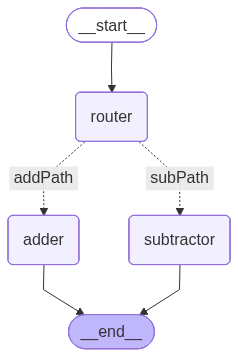

In [6]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

### Step 6: Test Drive
Let's try subtraction (`-`).

In [7]:
input_data = {"num1": 10, "num2": 3, "operator": "-"}
result = app.invoke(input_data)
print(f"Result: {result['result']}")

--- Router: Checking operator '-' ---
--- Worker: Subtractor ---
Result: 7


### Explanation
1. **Start**: Graph went to `router` node.
2. **Logic**: `routerFunc` saw "-" and returned "subPath".
3. **Routing**: The conditional edge mapping looked up "subPath" and saw it maps to "subtractor".
4. **Worker**: Graph went to `subtractor`. Node Calculated 10 - 3 = 7.
5. **End**: Graph went to `END`.